In [ ]:
#!pip install numpy pandas matplotlib seaborn scikit-learn ucimlrepo

In [ ]:
# Numerische Berechnungen
import numpy as np

# Daten und Visualisierung
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Maschinelles Lernen
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Preprocessing kategorischer und numerischer Merkmale für das Modell
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Umwandlung kateforialer Werte in numerische Codes
from sklearn.preprocessing import LabelEncoder

# Sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample

# Datei- und Pfadoperationen:
import os
from pathlib import Path
import zipfile
import urllib.request

In [ ]:
def load_adult_data():
    """
    Lädt das Adult Income Dataset von Kaggle herunter (falls nicht lokal vorhanden),
    entpackt die ZIP-Datei und gibt den Inhalt als Pandas DataFrame zurück.
    """

    # Pfad zur ZIP-Datei
    zip_path = Path("adult-income-dataset.zip")

    # Nur herunterladen, wenn die Datei noch nicht existiert
    if not zip_path.is_file():

        # URL definieren und Datensatz herunterladen
        url = "https://www.kaggle.com/api/v1/datasets/download/wenruliu/adult-income-dataset"
        urllib.request.urlretrieve(url, zip_path)

        # ZIP-Datei entpacken
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("adult_dataset")

    # CSV-Datei laden und als DataFrame zurückgeben
    csv_path = os.path.join("adult_dataset", "adult.csv")
    return pd.read_csv(csv_path)

In [ ]:
# Datensatz laden
df_adult = load_adult_data()

# Analyse eine KI-Modells

In [ ]:
# Datensatz in Trainings- (80 %) und Testdaten (20 %) aufteilen, um die Generalisierungsfähigkeit des Modells auf unbekannte Daten prüfen zu können
df_adult_train, df_adult_test = train_test_split(df_adult, test_size=0.2, random_state=42)

In [ ]:
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

# Pipeline für numerische Merkmale:
# Skaliert numerische Werte (Mittelwert 0, Std. 1), um stabile Modellleistung zu gewährleisten
default_num_pipeline = make_pipeline(StandardScaler())

# Kombinierte Vorverarbeitung:
# - Kategoriale Spalten → One-Hot-Encoding
# - Numerische Spalten → Skalierung
# Ziel: Einheitliches numerisches Format für alle Features
preprocess_data = ColumnTransformer(
    [("cat", cat_pipeline, make_column_selector(dtype_include=object))],
      remainder=default_num_pipeline
)

In [ ]:
# Trainings- und Testdaten in Features (X) und Targets (y) aufteilen.
# 'income' wird als Zielvariable entfernt, da sie vom Modell vorhergesagt werden soll.
X_train_adult_raw = df_adult_train.drop("income", axis=1)
y_train_adult = df_adult_train["income"]

X_test_adult_raw = df_adult_test.drop("income", axis=1)
y_test_adult = df_adult_test["income"]


# Trainings- und Testdaten vorverarbeiten (One-Hot-Encoding + Skalierung) -> vollständig numerisches Trainings-Array
X_train_adult = preprocess_data.fit_transform(X_train_adult_raw)
X_test_adult = preprocess_data.transform(X_test_adult_raw)

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_adult, y_train_adult)

LogisticRegression()

In [ ]:
tree = DecisionTreeClassifier(max_depth=10)
tree.fit(X_train_adult, y_train_adult)

DecisionTreeClassifier(max_depth=10)

In [ ]:
def analyse(model, X_train, y_train, X_test, y_test, positive_label=None):
    """
    Berechnet Accuracy, Precision und Recall für Trainings- und Testdaten.
    Zeigt pro Metrik die Differenz (Train-Test) an.
    Unterstützt binäre und Multiclass-Klassifikation.
    """

    # ANSI-Farbcodes (Konsole)
    RESET = "\033[0m"
    GREEN = "\033[92m"
    TURQUOISE = "\033[96m"
    YELLOW = "\033[93m"
    ORANGE = "\033[33m"
    RED_ORANGE = "\033[91m"
    DARK_RED = "\033[31m"

    # Farb-Funktion nach Accuracy
    def colorize(acc):
        """Gibt abhängig vom Wert eine passende Farbe zurück."""
        if acc < 70:
            return RED_ORANGE
        elif acc < 75:
            return DARK_RED
        elif acc < 80:
            return ORANGE
        elif acc < 85:
            return YELLOW
        elif acc < 90:
            return TURQUOISE
        else:
            return GREEN

    # Farb-Funktion für Differenzen
    def diff_colorize(diff):
        diff_abs = abs(diff)
        if diff_abs < 2:
            return GREEN
        elif diff_abs < 5:
            return YELLOW
        elif diff_abs < 10:
            return DARK_RED
        else:
            return RED_ORANGE

    # Vorhersagen
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Accuracy
    acc_train = accuracy_score(y_train, y_pred_train) * 100
    acc_test  = accuracy_score(y_test,  y_pred_test)  * 100
    acc_diff  = acc_train - acc_test

    # Klassen prüfen
    labels = np.unique(np.concatenate([np.unique(y_train), np.unique(y_test)]))
    is_binary = (len(labels) == 2)

    # Positives Label bestimmen
    if is_binary:
        if positive_label is None:
            if any(str(l).strip().startswith('>') for l in labels):
                positive_label = next(l for l in labels if str(l).strip().startswith('>'))
            else:
                positive_label = labels[1]

        prec_train = precision_score(y_train, y_pred_train, pos_label=positive_label, zero_division=0) * 100
        prec_test  = precision_score(y_test,  y_pred_test,  pos_label=positive_label, zero_division=0) * 100
        rec_train  = recall_score(y_train, y_pred_train, pos_label=positive_label, zero_division=0) * 100
        rec_test   = recall_score(y_test,  y_pred_test, pos_label=positive_label, zero_division=0) * 100
        pos_info   = f"(pos_label={positive_label})"
    else:
        prec_train = precision_score(y_train, y_pred_train, average='macro', zero_division=0) * 100
        prec_test  = precision_score(y_test,  y_pred_test,  average='macro', zero_division=0) * 100
        rec_train  = recall_score(y_train, y_pred_train, average='macro', zero_division=0) * 100
        rec_test   = recall_score(y_test,  y_pred_test,  average='macro', zero_division=0) * 100
        pos_info   = "(macro avg)"

    # Modellname automatisch erkennen (auch wenn 'model' eine Pipeline ist)
    est = model.steps[-1][1] if hasattr(model, "steps") else model
    if "LogisticRegression" in str(type(est)):
      model_name = "Logistische Regression"
    elif "DecisionTreeClassifier" in str(type(est)):
      model_name = "Entscheidungsbaum"
    else:
      model_name = "Unbekanntes Modell"


    # Differenzen berechnen
    prec_diff = prec_train - prec_test
    rec_diff  = rec_train - rec_test

    # Ausgabe
    print(
        f"{model_name} – Leistungswerte (in %) {pos_info}:\n"
        f"Accuracy:  Train {colorize(acc_train)}{acc_train:.2f}%{RESET} | "
        f"Test {colorize(acc_test)}{acc_test:.2f}%{RESET} "
        f"({diff_colorize(acc_diff)}Δ {acc_diff:+.2f}%{RESET})\n"
        f"Precision: Train {colorize(prec_train)}{prec_train:.2f}%{RESET} | "
        f"Test {colorize(prec_test)}{prec_test:.2f}%{RESET} "
        f"({diff_colorize(prec_diff)}Δ {prec_diff:+.2f}%{RESET})\n"
        f"Recall:    Train {colorize(rec_train)}{rec_train:.2f}%{RESET} | "
        f"Test {colorize(rec_test)}{rec_test:.2f}%{RESET} "
        f"({diff_colorize(rec_diff)}Δ {rec_diff:+.2f}%{RESET})\n"
    )

In [ ]:
analyse(log_reg, X_train_adult, y_train_adult, X_test_adult, y_test_adult, positive_label=">50K")
analyse(tree, X_train_adult, y_train_adult, X_test_adult, y_test_adult)

Logistische Regression – Leistungswerte (in %) (pos_label=>50K):
Accuracy:  Train 85.28% | Test 85.70% (Δ -0.42%)
Precision: Train 73.71% | Test 73.64% (Δ +0.08%)
Recall:    Train 60.31% | Test 60.74% (Δ -0.44%)

Entscheidungsbaum – Leistungswerte (in %) (pos_label=>50K):
Accuracy:  Train 86.93% | Test 86.35% (Δ +0.57%)
Precision: Train 79.69% | Test 76.33% (Δ +3.36%)
Recall:    Train 61.26% | Test 60.57% (Δ +0.70%)



# Prüfungung des Diskriminierungspotenzials

In [ ]:
def encode(df):
    """
    Kodiert alle kategorialen (object-)Spalten eines DataFrames mit LabelEncoder.

    Ziel:
        Viele ML-Modelle und statistische Methoden können nur mit numerischen Werten arbeiten.
        Diese Funktion wandelt daher alle Spalten mit Textwerten (dtype=object)
        in numerische Codes um, sodass z. B. Korrelationen berechnet oder Modelle trainiert
        werden können.

    Parameter:
        df (pd.DataFrame): Eingabedatensatz mit beliebigen Spalten (numerisch oder kategorisch)

    Rückgabe:
        pd.DataFrame: Eine Kopie des ursprünglichen DataFrames,
                      bei der alle kategorialen Spalten numerisch encodet wurden.
    """

    # Erstelle eine Kopie des DataFrames, damit das Original nicht verändert wird
    df_encoded = df.copy()

    encoders = {}  # Dictionary zum Speichern der LabelEncoder pro Spalte

    # Durchlaufe alle Spalten, deren Datentyp 'object' (also Text / Kategorie) ist
    for col in df_encoded.select_dtypes(include=['object']).columns:
        # Für jede Spalte wird ein eigener LabelEncoder erstellt
        le = LabelEncoder()

        # Wandle alle Werte der Spalte in Strings um (für den Fall, dass gemischte Typen vorhanden sind)
        # und fit-transformiere sie → jeder einzigartige Wert bekommt eine eindeutige Zahl
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        encoders[col] = le  # Speichere Encoder für spätere Dekodierung

    return df_encoded, encoders

In [ ]:
def decode(df_encoded, encoders):
    """
    Dekodiert alle zuvor mit LabelEncoder kodierten Spalten wieder zurück in Textwerte.

    Parameter:
        df_encoded (pd.DataFrame): Der numerisch kodierte DataFrame.
        encoders (dict): Dictionary mit LabelEncodern aus der encode()-Funktion.

    Rückgabe:
        pd.DataFrame: DataFrame mit wiederhergestellten kategorialen Spalten.
    """
    df_decoded = df_encoded.copy()

    for col, le in encoders.items():
        if col in df_decoded.columns:
            df_decoded[col] = le.inverse_transform(df_decoded[col].astype(int))

    return df_decoded

In [ ]:
def plot_correlation_heatmap(df, title="Korrelationen zwischen allen Attributen (numerisch & kategorial codiert)"):
    """
    Erstellt eine Korrelations-Heatmap für numerische und kategoriale Variablen im Datensatz.

    Alle kategorialen Spalten werden automatisch label-encodet, damit sie in die Berechnung
    der Korrelationsmatrix (numerisch) einbezogen werden können.

    Parameter:
        df (pd.DataFrame): Eingabedatensatz (enthält numerische und/oder kategoriale Spalten)
        title (str): Titel der Heatmap (optional)

    Wirkung:
        - Wandelt kategoriale Spalten intern mit LabelEncoder in numerische Werte um
        - Berechnet die Korrelationsmatrix
        - Zeigt eine farbige Heatmap mit annotierten Korrelationswerten
    """

    # Korrelationsmatrix berechnen
    df_encoded, _ = encode(df)
    corr_matrix = df_encoded.corr()

    # Heatmap plotten
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f")
    plt.title(title)
    plt.tight_layout()
    plt.show()

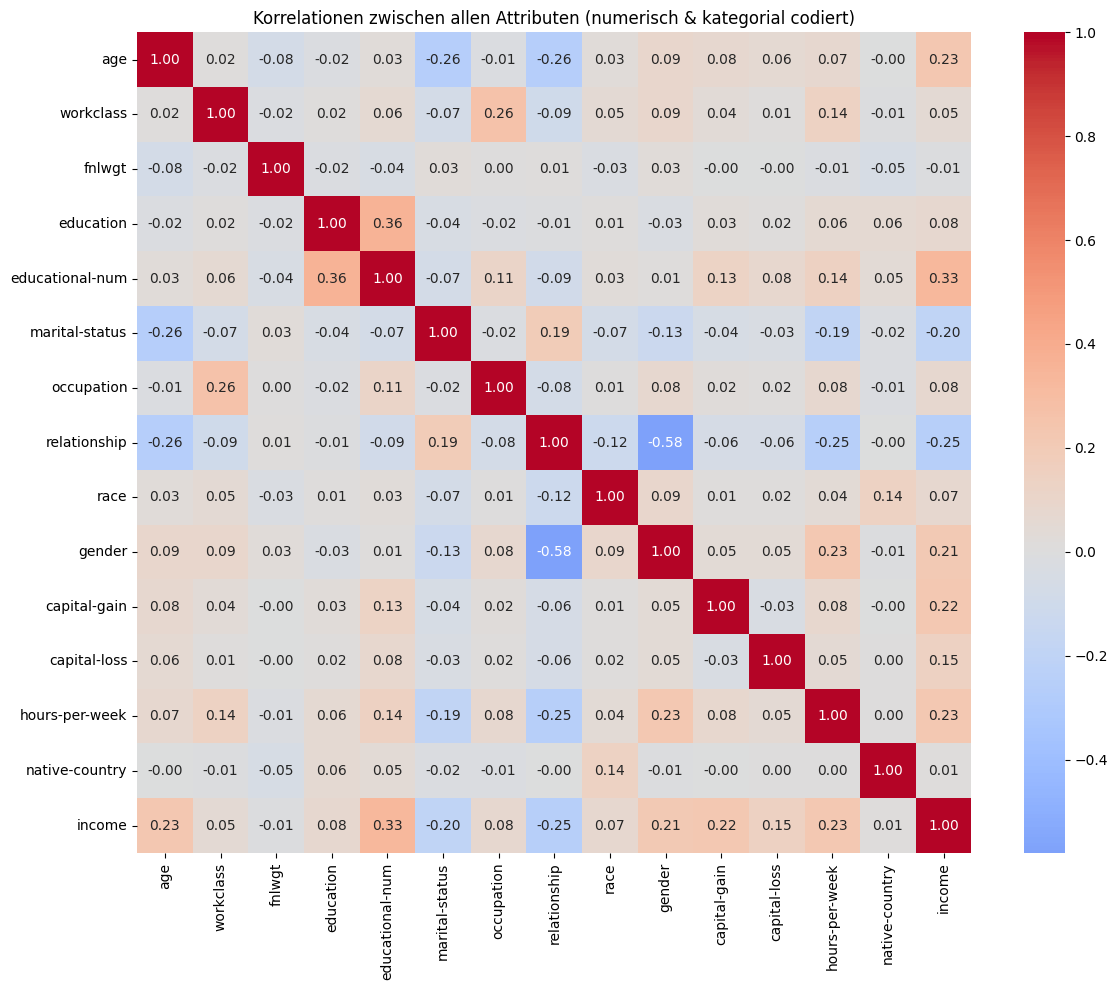

In [ ]:
plot_correlation_heatmap(df_adult)

In [ ]:
df_adult['gender'].value_counts()

,count
gender,
Male,32650
Female,16192


In [ ]:
df_adult[['gender', 'income']].value_counts()

,,count
gender,income,
Male,<=50K,22732
Female,<=50K,14423
Male,>50K,9918
Female,>50K,1769


In [ ]:
# Prozentuale Verteilung des Einkommens innerhalb jeder Rasse berechnen
income_percent = (
    df_adult.groupby('race')['income']
    .value_counts(normalize=True)   # relative Häufigkeit statt absoluter Zahl
    .mul(100)                       # in Prozent umrechnen
    .rename('percent')              # Spalte benennen
    .reset_index()
)

# Schön formatiert anzeigen
print(income_percent)

                 race income    percent
0  Amer-Indian-Eskimo  <=50K  88.297872
1  Amer-Indian-Eskimo   >50K  11.702128
2  Asian-Pac-Islander  <=50K  73.074391
3  Asian-Pac-Islander   >50K  26.925609
4               Black  <=50K  87.918890
5               Black   >50K  12.081110
6               Other  <=50K  87.684729
7               Other   >50K  12.315271
8               White  <=50K  74.601312
9               White   >50K  25.398688


# Bias Bekämpfung - SMOTE

In [ ]:
# SMOTE initialisieren
smote = SMOTE(random_state=42)

In [ ]:
# Datensatz kopieren
df_decoded, encoders = encode(df_adult)

In [ ]:
# Kategoriale Werte encoden und Zielspalte trennen
X = df_decoded.drop('gender', axis=1)
y = df_decoded['gender']

# Datensatz neu sampeln (synthetische Stichproben für Minoritätsklasse erzeugen)
X_smote, y_smote = smote.fit_resample(X, y)

# Neues DataFrame mit Features und Zielvariable erstellen
df_smote = pd.DataFrame(X_smote)
df_smote["gender"] = y_smote

In [ ]:
# Decodieren
df_smote = decode(df_smote, encoders)

In [ ]:
# Klassenverteilung anzeigen, um Balance zu überprüfen
df_smote["gender"].value_counts()

,count
gender,
Male,32650
Female,32650


# Testen für Bias

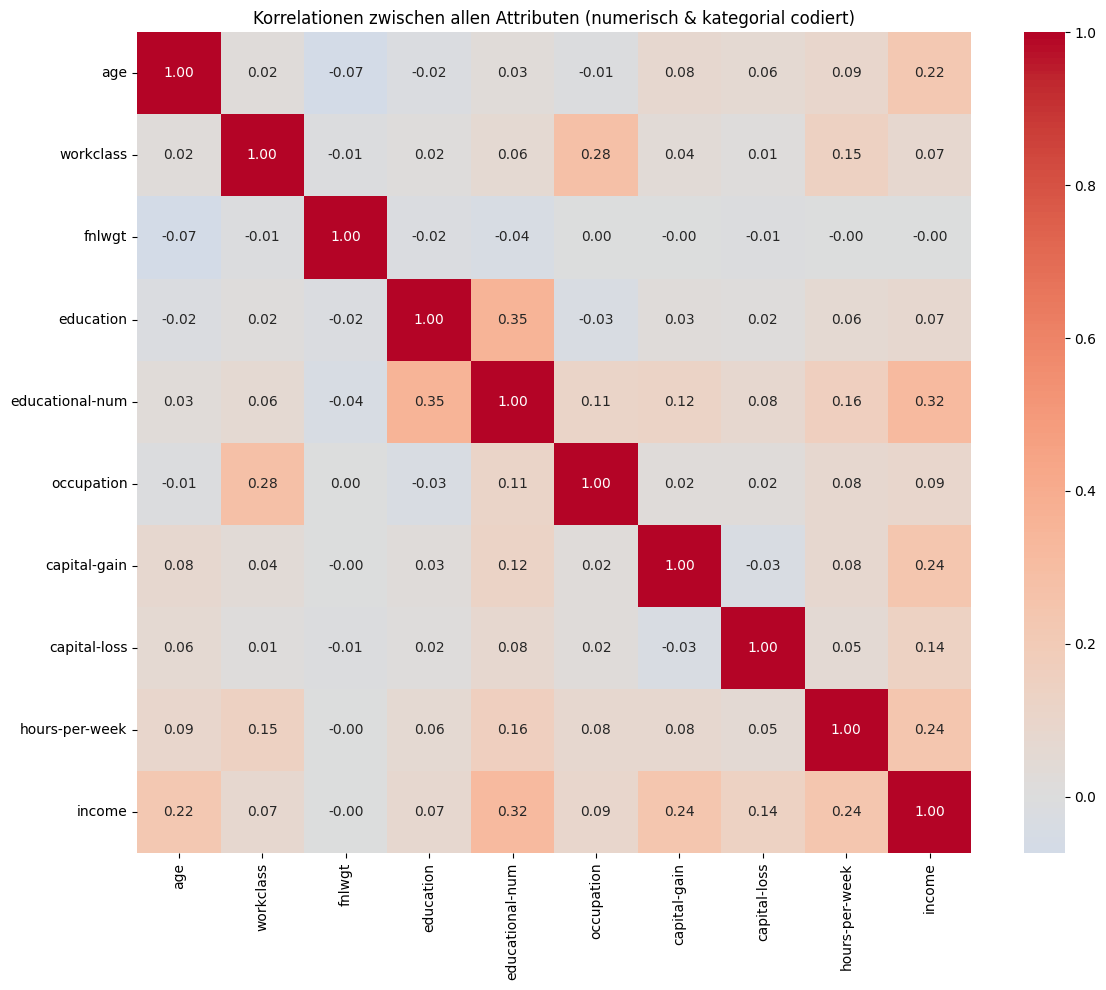

In [ ]:
plot_correlation_heatmap(df_smote.drop(["gender", "relationship", "marital-status", "race", "native-country"], axis=1))

**Schlussfolgerung:**

Die Heatmap zeigt keine Hinweise auf Bias. Die Korrelationen betreffen nur sachlich erklärbare Merkmale wie Bildung, Alter und Arbeitszeit, während sensible Attribute fehlen.


**Problem:**

Das Modell ist formal fair, kann aber immernoch indirekten Bias enthalten

# Cost-Sensitive Learning

In [ ]:
def run_cost_sensitive_training(df_smote):
    """
    Ziel dieser Funktion
    --------------------
    Wir trainieren zwei Modelle (Logistische Regression & Entscheidungsbaum) so,
    dass bestimmte Beispiele im Training "wichtiger" sind. Das machen wir über
    `sample_weight`. Dadurch können wir:

    1) Feature-Wichtigkeit berücksichtigen (z. B. viele Arbeitsstunden -> etwas wichtiger)
    2) Fairness-Ziele verfolgen (z. B. weibliche >50K-Fälle besonders stark gewichten,
       damit das Modell dort weniger "übersehen" -> weniger False Negatives bei Frauen)

    WICHTIG: Die 5 sensiblen Spalten (gender, relationship, marital-status, race,
    native-country) werden NICHT als Input-Features benutzt, fließen aber in die
    Gewichte ein (Fairness).
    """

    # 1) Grund-Konfiguration
    target = "income"
    sensitive_cols = ["gender", "relationship", "marital-status", "race", "native-country"]
    pos_label = ">50K"  # positive Klasse
    rnd = 42            # Zufalls-Seed für Reproduzierbarkeit

    # (a) "Wichtigkeit" ausgewählter Features:
    #     Werte >1.0 machen diese Zeilen leicht wichtiger
    feature_weights = {
        "hours-per-week": 1.5,
        "capital-gain": 1.3,
        "education": 1.0,
        "educational-num": 1.0,
        "workclass": 1.0,
        "occupation": 1.0,
        "age": 1.0,
        "capital-loss": 1.3,
        "fnlwgt": 1.0,
        "native-country": 1.0,
    }

    # (b) Fairness-Regeln mit starkem Effekt:
    #     - Female & >50K sehr hoch -> Modell "kostet" es viel, diese Fälle falsch zu machen
    #     - Female allgemein etwas höher
    #     - Male & <=50K leicht niedriger (damit die Grenze etwas Richtung >50K rutscht)
    penalty_rules = [
        {"when": {"gender": ["Female"], "label": [pos_label]}, "factor": 12.0},
        {"when": {"gender": ["Female"]},                      "factor": 2.0},
        {"when": {"gender": ["Male"],   "label": ["<=50K"]},  "factor": 0.7},
    ]

    # 2) Daten vorbereiten
    # Feature-Tabelle ohne Zielspalte
    X_full = df_smote.drop(columns=[target])
    y_full = df_smote[target]
    # Sensible Spalten separat aufbewahren (nur für Gewichte)
    S_full = df_smote[[c for c in sensitive_cols if c in df_smote.columns]]

    # Train/Test-Split:
    #  - Sensible Spalten NICHT als Features ins Modell geben
    #  - aber parallel "S_train/S_test" mitschneiden für die Fairness-Gewichte
    X_train, X_test, y_train, y_test, S_train, S_test = train_test_split(
        X_full.drop(columns=[c for c in sensitive_cols if c in X_full.columns]),
        y_full,
        S_full,
        stratify=y_full,
        random_state=rnd
    )

    # 3) Vorverarbeitung (One-Hot für Kategorisches, Skalierung für Numerisches)
    cat_cols = X_train.select_dtypes(include="object").columns
    num_cols = X_train.select_dtypes(exclude="object").columns
    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
            ("num", StandardScaler(with_mean=False), num_cols),
        ],
        remainder="drop",
    )

    # 4) sample_weight konstruieren
    # Startgewicht = 1.0 (alle Zeilen gleich wichtig)
    w_train = np.ones(len(X_train), dtype=float)

    # 4a) Feature-Wichtigkeit (moderat):
    #     Für numerische Spalten normalisieren wir auf [0..1] und skalieren dann
    #     linear in Richtung "factor". So werden hohe Werte leicht wichtiger.
    for col, fac in feature_weights.items():
        if col not in X_train.columns:
            continue
        s = X_train[col]
        if np.issubdtype(s.dtype, np.number):
            vals = s.to_numpy(dtype=float)
            vmin, vmax = np.nanmin(vals), np.nanmax(vals)
            if vmax > vmin:
                norm = (vals - vmin) / (vmax - vmin + 1e-9)
                w_train *= (1.0 + (fac - 1.0) * norm)
        else:
            # Kategorial: nur "hat Wert" → sehr milder Effekt
            w_train *= np.where(s.notna(), fac, 1.0)

    # 4b) Fairness-Regeln (stark, gruppen- und labelabhängig):
    #     Jede Regel baut eine Maske (welche Zeilen gelten?) und multipliziert den Faktor.
    y_arr = y_train.to_numpy()
    for rule in penalty_rules:
        when = rule.get("when", {})
        fac = float(rule.get("factor", 1.0))
        if fac == 1.0 or not when:
            continue

        mask = np.ones(len(y_train), dtype=bool)
        for key, allowed in when.items():
            allowed_set = set(allowed)
            if key == "label":
                # Bedingung auf die Zielklasse (>50K oder <=50K)
                mask &= np.isin(y_arr, list(allowed_set))
            else:
                # Bedingung auf eine (sensitive) Spalte (z. B. gender == Female)
                col = S_train[key] if key in S_train.columns else (X_train[key] if key in X_train.columns else None)
                if col is None:
                    mask &= False
                else:
                    mask &= np.isin(col.astype(object).to_numpy(), list(allowed_set))

        w_train[mask] *= fac  # Faktor anwenden

    # 4c) Sicherheitsgrenzen (sonst kann die Optimierung instabil werden)
    w_train = np.clip(w_train, 0.1, 50.0)

    # 5) Modelle definieren
    # Logistische Regression: weniger Regularisierung (C↑), damit Gewichte stärker wirken.
    pipe_logreg = make_pipeline(
        pre,
        LogisticRegression(max_iter=8000, solver="saga", C=5.0)
    )
    # Entscheidungsbaum: kleinere Blätter & etwas mehr Tiefe -> reagiert stärker auf Gewichte.
    pipe_tree = make_pipeline(
        pre,
        DecisionTreeClassifier(max_depth=12, min_samples_leaf=10, random_state=rnd)
    )

    # Training: sample_weight muss bis zum letzten Schritt durchgereicht werden
    pipe_logreg.fit(X_train, y_train, **{"logisticregression__sample_weight": w_train})
    pipe_tree.fit(  X_train, y_train, **{"decisiontreeclassifier__sample_weight": w_train})

    # 6) Auswertung
    analyse(pipe_logreg, X_train, y_train, X_test, y_test, positive_label=pos_label)
    analyse(pipe_tree,   X_train, y_train, X_test, y_test, positive_label=pos_label)

    print(f"[Weights] min={w_train.min():.2f}  max={w_train.max():.2f}  mean={w_train.mean():.2f}\n")
    # 7) Fairness-Check: Recall (Frauen vs. Männer)
    # Idee:
    #   - Wir berechnen den Recall getrennt für Frauen und Männer.
    #   - Recall = Anteil der tatsächlich positiven Fälle (>50K), die korrekt erkannt wurden.
    #   - Der "Gap" ist der absolute Unterschied der beiden Recalls.
    #     Je kleiner der Gap, desto fairer ist das Modell (Equality of Opportunity).

    try:
      RESET = "\033[0m"
      GREEN = "\033[92m"
      YELLOW = "\033[93m"
      RED   = "\033[91m"

      def color_for_gap(g):
          """Kleine Gaps = gut (grün), mittlere = Achtung (gelb), große = schlecht (rot)."""
          if g <= 0.02:     # sehr fair
              return GREEN
          elif g <= 0.05:   # noch ok, aber beobachten
              return YELLOW
          else:             # wahrscheinlich unfair
              return RED

      # Vorhersagen beider Modelle
      yp_lr = pipe_logreg.predict(X_test)
      yp_dt = pipe_tree.predict(X_test)

      # Für jedes Modell: Recall pro Gruppe + Gap berechnen und farbig ausgeben
      for name, yp in [("LR", yp_lr), ("DT", yp_dt)]:
          # Masken für Frauen/Männer im Testset
          mask_f = (S_test["gender"] == "Female")
          mask_m = (S_test["gender"] == "Male")

          # Recall getrennt berechnen
          rec_f = recall_score(y_test[mask_f], yp[mask_f], pos_label=pos_label, zero_division=0)
          rec_m = recall_score(y_test[mask_m], yp[mask_m], pos_label=pos_label, zero_division=0)

          gap = abs(rec_f - rec_m)
          c = color_for_gap(gap)

          print(
              f"{name}: Recall Female={rec_f:.3f} | "
              f"Male={rec_m:.3f} | "
              f"Gap={c}{gap:.3f}{RESET}"
          )
    except Exception as e:
          # Falls z. B. die Spalte 'gender' fehlt, nicht abbrechen
          print(f"[Fairness-Check skipped] {e}")


# Analyse von Modelltraining auf Subgruppen

In [ ]:
# Datensatz in Trainings- (80 %) und Testdaten (20 %) aufteilen, um die Generalisierungsfähigkeit des Modells auf unbekannte Daten prüfen zu können
df_smote_train, df_smote_test = train_test_split(df_smote, test_size=0.2, random_state=42)

In [ ]:
target = "income"

drop_origin = [target]
drop_rm = [target, "gender", "relationship", "marital-status", "race", "native-country","age","workclass","education","educational-num","occupation"]
drop_smote = [target]

depth = 10


# Trainings- und Testdaten in Features (X) und Targets (y) aufteilen.
# 'income' wird als Zielvariable entfernt, da sie vom Modell vorhergesagt werden soll.
X_train_origin_raw = df_adult_train.drop(drop_origin, axis=1)
y_train_origin = df_adult_train[target]

X_test_origin_raw = df_adult_test.drop(drop_origin, axis=1)
y_test_origin = df_adult_test[target]

# Trainings- und Testdaten vorverarbeiten (One-Hot-Encoding + Skalierung) -> vollständig numerisches Trainings-Array
X_train_origin= preprocess_data.fit_transform(X_train_origin_raw)
X_test_origin = preprocess_data.transform(X_test_origin_raw)



# Trainings- und Testdaten in Features (X) und Targets (y) aufteilen.
# 'income' wird als Zielvariable entfernt, da sie vom Modell vorhergesagt werden soll.
X_train_rm_raw = df_adult_train.drop(drop_rm, axis=1)
y_train_rm = df_adult_train[target]

X_test_rm_raw = df_adult_test.drop(drop_rm, axis=1)
y_test_rm = df_adult_test[target]

# Trainings- und Testdaten vorverarbeiten (One-Hot-Encoding + Skalierung) -> vollständig numerisches Trainings-Array
X_train_rm= preprocess_data.fit_transform(X_train_rm_raw)
X_test_rm = preprocess_data.transform(X_test_rm_raw)



# Trainings- und Testdaten in Features (X) und Targets (y) aufteilen.
# 'income' wird als Zielvariable entfernt, da sie vom Modell vorhergesagt werden soll.
X_train_smote_raw = df_smote_train.drop(drop_smote, axis=1)
y_train_smote = df_smote_train[target]

X_test_smote_raw = df_smote_test.drop(drop_smote, axis=1)
y_test_smote = df_smote_test[target]

# Trainings- und Testdaten vorverarbeiten (One-Hot-Encoding + Skalierung) -> vollständig numerisches Trainings-Array
X_train_smote = preprocess_data.fit_transform(X_train_smote_raw)
X_test_smote = preprocess_data.transform(X_test_smote_raw)



origin_log_reg = LogisticRegression()
origin_log_reg.fit(X_train_origin, y_train_origin)

origin_tree = DecisionTreeClassifier(max_depth=10)
origin_tree.fit(X_train_origin, y_train_origin)



rm_log_reg = LogisticRegression()
rm_log_reg.fit(X_train_rm, y_train_rm)

rm_tree = DecisionTreeClassifier(max_depth=10)
rm_tree.fit(X_train_rm, y_train_rm)



smote_log_reg = LogisticRegression()
smote_log_reg.fit(X_train_smote, y_train_smote)

smote_tree = DecisionTreeClassifier(max_depth=depth)
smote_tree.fit(X_train_smote, y_train_smote)



print("===== Original Dataset =====\n")
analyse(origin_log_reg, X_train_origin, y_train_origin, X_test_origin, y_test_origin)
analyse(origin_tree, X_train_origin, y_train_origin, X_test_origin, y_test_origin)
print("===== Original Dataset (removed features) =====\n")
analyse(rm_log_reg, X_train_rm, y_train_rm, X_test_rm, y_test_rm)
analyse(rm_tree, X_train_rm, y_train_rm, X_test_rm, y_test_rm)
print("===== SMOTE Dataset =====\n")
analyse(smote_log_reg, X_train_smote, y_train_smote, X_test_smote, y_test_smote)
analyse(smote_tree, X_train_smote, y_train_smote, X_test_smote, y_test_smote)
print("===== Cost-Sensitive Modell =====\n")
run_cost_sensitive_training(df_smote)

===== Original Dataset =====

Logistische Regression – Leistungswerte (in %) (pos_label=>50K):
Accuracy:  Train 85.28% | Test 85.70% (Δ -0.42%)
Precision: Train 73.71% | Test 73.64% (Δ +0.08%)
Recall:    Train 60.31% | Test 60.74% (Δ -0.44%)

Entscheidungsbaum – Leistungswerte (in %) (pos_label=>50K):
Accuracy:  Train 86.92% | Test 86.37% (Δ +0.56%)
Precision: Train 79.71% | Test 76.46% (Δ +3.25%)
Recall:    Train 61.21% | Test 60.44% (Δ +0.77%)

===== Original Dataset (removed features) =====

Logistische Regression – Leistungswerte (in %) (pos_label=>50K):
Accuracy:  Train 79.91% | Test 80.69% (Δ -0.78%)
Precision: Train 72.01% | Test 73.60% (Δ -1.58%)
Recall:    Train 26.94% | Test 27.51% (Δ -0.57%)

Entscheidungsbaum – Leistungswerte (in %) (pos_label=>50K):
Accuracy:  Train 83.10% | Test 83.17% (Δ -0.07%)
Precision: Train 98.14% | Test 95.24% (Δ +2.90%)
Recall:    Train 30.32% | Test 29.69% (Δ +0.62%)

===== SMOTE Dataset =====

Logistische Regression – Leistungswerte (in %) (pos_

**Schlussfolgerung:**

Das Modell zeigt keine signifikanten geschlechtsspezifischen Verzerrungen. Die geringen Recall-Differenzen (Gap ≤ 0.01) belegen eine faire und ausgewogene Klassifikation. Durch Verfahren wie Feature-Reduktion, SMOTE und kosten-sensitives Lernen wurde ein weitgehend biasfreies Modell erzielt.

**Anmerkung:**

Ein vollständig biasfreies Modell erfordert eine Erweiterung des Datensatzes um vielfältigere und repräsentativere Geschlechtskategorien sowie zusätzliche, ausgewogene Daten, da die aktuelle Datengrundlage dies nicht abbildet.